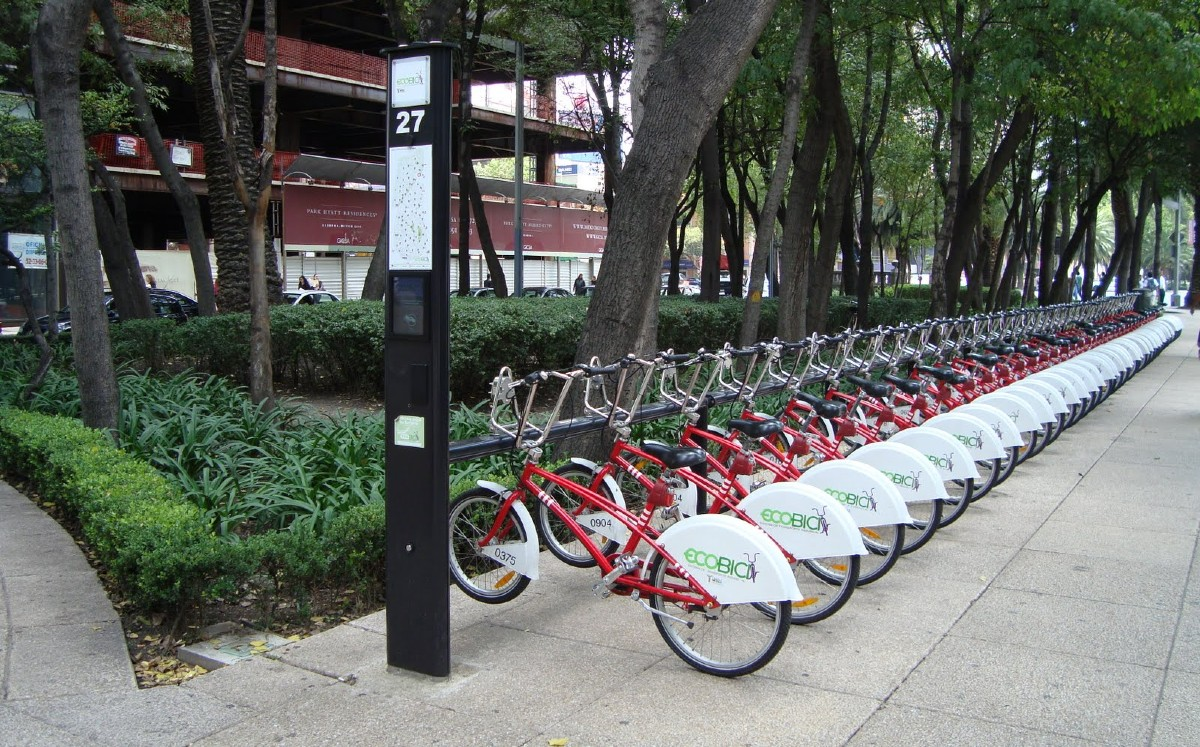

ECOBICI en su página de internet publica los datos de movibilidad bicicletas en tiempo real, y sobre sobre la disponibilidad en cicloestaciones con el estándar GBFS (General Bikeshare Feed Specification). Contiene datos mensuales desde febrero del 2010, en formatos JSON, y CSV, con la sigueinte información:

- **Genero_Usuario**          : Masculino(M) o femenino (F)
- **Edad_Usuario**	          : Edad en valor entero
- **Bici**	                  : Número de identificación de bici
- **Ciclo_Estacion_Retiro**	  : Número de estación de retiro
- **Fecha_Retiro**	          : Fecha de retiro de la bici
- **Hora_Retiro**	            : Hora de retiro de la bici
- **Ciclo_EstacionArribo**	  : Número de estación de arribo
- **Fecha Arribo**	          : Fecha de arribo
- **Hora_Arribo**             : Horav de arribo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ipysigma import Sigma
import requests
from sqlalchemy import create_engine
import sys
import json
import pymysql
import mysql
import mysql.connector
from mysql.connector import Error
import math 
import os
from functions import MySQLDatabase
from pyvis.network import Network
import plotly.graph_objects as go
sns.set_theme()

In [4]:
db = MySQLDatabase("ecobicis")

In [2]:
year = '2024'

In [ ]:
query = f"""  
    SELECT 
        year(Fecha_Retiro) AS anio,
        Ciclo_Estacion_Retiro AS source,
        Ciclo_Estacion_Arribo AS target,
        count(*)  AS total_viajes
    FROM viajes2
    WHERE year(Fecha_Retiro) = '{year}' AND 
        Ciclo_Estacion_Retiro IS NOT NULL AND 
        Ciclo_Estacion_Arribo IS NOT NULL
    GROUP BY year(Fecha_Retiro), Ciclo_Estacion_Retiro, Ciclo_Estacion_Arribo;
"""

df = db.execute_query(query)
df.head()

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [111]:
# df_edges = (
#     df.groupby(['Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo'])
#       .size()
#       .reset_index(name='total_viajes')
# )
# df_edges

**segundo**

In [ ]:
df[df['source']=='282']['total_viajes'].count()

In [ ]:
df[df['target']=='282']['total_viajes'].count()

In [ ]:
size = 3228+3371
size

In [8]:
# --- Limpieza y construcción del grafo ---
df2 = df[['source', 'target', 'total_viajes']].dropna()

# Crear grafo dirigido
G = nx.DiGraph()

# Añadir aristas con atributo total_viajes
for _, row in df2.iterrows():
    G.add_edge(row['source'], row['target'], total_viajes=row['total_viajes'])

# Calcular tamaño de nodo basado en total_viajes (suma de edges asociados)
node_weights = {}
for u, v, data in G.edges(data=True):
    w = data['total_viajes']
    node_weights[u] = node_weights.get(u, 0) + w
    node_weights[v] = node_weights.get(v, 0) + w

# Asignar tamaño a cada nodo
nx.set_node_attributes(G, node_weights, 'size')

# --- Conversión de tipos para compatibilidad JSON ---
for node in G.nodes(data=True):
    for key, value in node[1].items():
        if isinstance(value, (np.integer, np.int64)):
            G.nodes[node[0]][key] = int(value)
        elif isinstance(value, (np.floating, np.float64)):
            G.nodes[node[0]][key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            G.nodes[node[0]][key] = value.tolist()

for edge in G.edges(data=True):
    for key, value in edge[2].items():
        if isinstance(value, (np.integer, np.int64)):
            G.edges[edge[0], edge[1]][key] = int(value)
        elif isinstance(value, (np.floating, np.float64)):
            G.edges[edge[0], edge[1]][key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            G.edges[edge[0], edge[1]][key] = value.tolist()

# --- JSON encoder para numpy ---
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, (np.integer, np.int64)):
#             return int(obj)
#         elif isinstance(obj, (np.floating, np.float64)):
#             return float(obj)
#         elif isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super().default(obj)

# --- Exportar grafo con Sigma ---
Sigma.write_html(
    G,
    f"./grafos/year_{year}.html",
    fullscreen=True,
    node_metrics=['louvain'],
    node_color='louvain',
    node_size='size',              # tamaño de nodo según total_viajes
    node_size_range=(1, 20),
    max_categorical_colors=30,
    default_edge_type='curve',
    node_border_color_from='node',
    default_node_label_size=12,
    edge_label='total_viajes'      # etiqueta visible en cada arista
)


# Análisis

In [31]:
import matplotlib.pyplot as plt
import math
from collections import Counter
import statistics
from scipy import stats
try:
    import community as community_louvain  # python-louvain
except Exception:
    community_louvain = None

In [32]:
# -------------------------
# Helpers / carga del grafo
# -------------------------
def load_graph_from_edgelist(path, directed=False, weighted=False):
    """Carga un grafo desde un edgelist (u v [w])."""
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    if weighted:
        G = nx.read_weighted_edgelist(path, create_using=G)
    else:
        G = nx.read_edgelist(path, create_using=G)
    return G

def build_example_graph():
    """Construye un grafo de ejemplo (puedes reemplazarlo por tu propio G)."""
    G = nx.karate_club_graph()  # grafo clásico de ejemplo (no dirigido)
    return G

# -------------------------
# Métricas básicas
# -------------------------
def basic_stats(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    directed = G.is_directed()
    weights = nx.get_edge_attributes(G, 'weight')
    avg_deg = sum(dict(G.degree()).values()) / float(n) if n>0 else 0
    density = nx.density(G)
    components = nx.number_connected_components(G) if not directed else nx.number_weakly_connected_components(G)
    stats = {
        'nodes': n,
        'edges': m,
        'directed': directed,
        'weighted': len(weights) > 0,
        'avg_degree': avg_deg,
        'density': density,
        'components': components
    }
    return stats

# -------------------------
# Distribuciones y grados
# -------------------------
def degree_distribution(G, plot=True, savepath=None):
    deg_seq = sorted([d for n, d in G.degree()], reverse=True)
    counts = Counter(deg_seq)
    degs = np.array(sorted(counts.keys()))
    freqs = np.array([counts[d] for d in degs])
    if plot:
        plt.figure(figsize=(6,4))
        plt.loglog(degs, freqs, marker='o', linestyle='None')
        plt.xlabel('grado k')
        plt.ylabel('cantidad de nodos')
        plt.title('Distribución de grado (log-log)')
        if savepath: plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()
    return degs, freqs, deg_seq

# Ajuste simple de cola con power-law (método mínimo-squares en log)
def fit_powerlaw_tail(deg_seq, xmin=None):
    degs = np.array(deg_seq)
    degs = degs[degs>0]
    if xmin is None:
        xmin = np.percentile(degs, 50)  # heurística inicial
    tail = degs[degs>=xmin]
    if len(tail) < 2:
        return None
    # estimador de MLE para power-law p(k) ~ k^{-alpha} (continua aproximada)
    # alpha_hat = 1 + n / sum(log(k/xmin))
    n = len(tail)
    alpha = 1 + n / np.sum(np.log(tail / float(xmin)))
    return {'alpha': alpha, 'xmin': xmin, 'n_tail': n}

# -------------------------
# Centralidades
# -------------------------
def compute_centralities(G):
    deg = dict(G.degree())
    try:
        clos = nx.closeness_centrality(G)
    except Exception:
        clos = None
    try:
        bet = nx.betweenness_centrality(G, normalized=True)
    except Exception:
        bet = None
    try:
        eig = nx.eigenvector_centrality_numpy(G)
    except Exception:
        eig = None
    try:
        pagerank = nx.pagerank(G)
    except Exception:
        pagerank = None
    return {'degree': deg, 'closeness': clos, 'betweenness': bet, 'eigenvector': eig, 'pagerank': pagerank}

# -------------------------
# Community detection
# -------------------------
def detect_communities_louvain(G):
    if community_louvain is None:
        raise ImportError("python-louvain no está instalado. pip install python-louvain")
    if G.is_directed():
        H = G.to_undirected()
    else:
        H = G
    partition = community_louvain.best_partition(H)
    # partition: {node: community_id}
    # calcular modularidad
    modularity = community_louvain.modularity(partition, H)
    return partition, modularity

# Alternativa: usar networkx.community greedy_modularity_communities
def detect_communities_greedy(G):
    if G.is_directed():
        H = G.to_undirected()
    else:
        H = G
    comms = list(nx.algorithms.community.greedy_modularity_communities(H))
    membership = {}
    for cid, comm in enumerate(comms):
        for node in comm:
            membership[node] = cid
    # modularidad con networkx
    mod = nx.algorithms.community.quality.modularity(H, comms)
    return membership, mod

# -------------------------
# Clustering, assortativity, triads
# -------------------------
def clustering_and_assortativity(G):
    avg_clustering = nx.average_clustering(G)
    trans = nx.transitivity(G)  # global transitivity (triangles)
    try:
        assort_deg = nx.degree_pearson_correlation_coefficient(G)
    except Exception:
        assort_deg = None
    triangles = sum(nx.triangles(G).values()) // 3 if not G.is_directed() else None
    return {'avg_clustering': avg_clustering, 'transitivity': trans, 'assortativity_deg': assort_deg, 'triangles': triangles}

# -------------------------
# Paths, distancia, diametro
# -------------------------
def distance_measures(G):
    if G.is_directed():
        H = G.to_undirected()
    else:
        H = G
    # usa componente gigante
    components = sorted(nx.connected_components(H), key=len, reverse=True)
    giant = H.subgraph(components[0]).copy() if components else H
    try:
        diameter = nx.diameter(giant)
    except Exception:
        diameter = None
    try:
        avg_shortest = nx.average_shortest_path_length(giant)
    except Exception:
        avg_shortest = None
    try:
        radius = nx.radius(giant)
    except Exception:
        radius = None
    return {'diameter': diameter, 'avg_shortest_path': avg_shortest, 'radius': radius, 'giant_size': giant.number_of_nodes()}

# -------------------------
# Spectral analysis
# -------------------------
def spectral_analysis(G, k=10, plot=True, savepath=None):
    A = nx.to_numpy_array(G)
    # Laplacian
    L = nx.normalized_laplacian_matrix(G).astype(float).todense()
    eigvals, eigvecs = np.linalg.eigh(L)
    # valores propios pequeños: conectividad, número de componentes, expansión
    if plot:
        plt.figure(figsize=(6,3))
        plt.plot(range(len(eigvals)), sorted(eigvals), marker='o')
        plt.xlabel('índice')
        plt.ylabel('valor propio (laplaciano normalizado)')
        plt.title('Espectro del Laplaciano normalizado')
        if savepath: plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()
    return eigvals, eigvecs

# -------------------------
# Robustez / ataques
# -------------------------
def robustness_attack(G, strategy='degree', fraction=0.2):
    """
    Simula eliminación de nodos por estrategia hasta cierta fracción.
    strategy: 'degree' (por grado descendente) o 'random'
    Retorna lista de tamaños de componente gigante tras cada eliminación.
    """
    H = G.copy()
    n = H.number_of_nodes()
    steps = int(n * fraction)
    giant_sizes = []
    nodes = list(H.nodes())
    if strategy == 'random':
        np.random.shuffle(nodes)
    else:
        # ordenar por grado inicial (descendente)
        nodes = sorted(nodes, key=lambda x: H.degree(x), reverse=True)
    for i in range(steps):
        if not nodes:
            break
        node = nodes.pop(0)
        if H.has_node(node):
            H.remove_node(node)
        if H.number_of_nodes() == 0:
            giant_sizes.append(0)
        else:
            if H.is_directed():
                comp = max(nx.weakly_connected_components(H), key=len)
            else:
                comp = max(nx.connected_components(H), key=len)
            giant_sizes.append(len(comp))
    return giant_sizes

# -------------------------
# Visualizaciones
# -------------------------
def draw_graph(G, node_size_attr=None, node_color_attr=None, with_labels=False, figsize=(8,6), savepath=None):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=42)  # layout reproducible
    node_sizes = None
    if node_size_attr:
        vals = np.array([node_size_attr.get(n, 1) for n in G.nodes()])
        # escalar
        node_sizes = 50 + 300 * (vals - vals.min()) / (vals.ptp() if vals.ptp()!=0 else 1)
    node_colors = None
    if node_color_attr:
        vals = np.array([node_color_attr.get(n, 0) for n in G.nodes()])
        node_colors = vals
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=8)
    plt.axis('off')
    if savepath: plt.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()

In [33]:
def full_analysis(G, saveplots_prefix=None):
    print("== Estadísticos básicos ==")
    s = basic_stats(G)
    for k,v in s.items(): print(f"{k}: {v}")
    print("\n== Distribución de grado ==")
    degs, freqs, deg_seq = degree_distribution(G, plot=True, savepath=(saveplots_prefix+"_deg.png" if saveplots_prefix else None))
    plfit = fit_powerlaw_tail(deg_seq)
    print("Power-law fit (cola):", plfit)
    print("\n== Centralidades (top 10 degree, betweenness, eigenvector) ==")
    centr = compute_centralities(G)
    # show top 10 for each
    for name in ['degree', 'betweenness', 'eigenvector', 'pagerank']:
        vals = centr.get(name)
        if vals:
            top = sorted(vals.items(), key=lambda x: x[1], reverse=True)[:10]
            print(f"Top {name}:", top)
    print("\n== Comunidades (Louvain o greedy) ==")
    try:
        part, mod = detect_communities_louvain(G)
        print("Louvain modularity:", mod, "n_communities:", len(set(part.values())))
    except Exception as e:
        print("Louvain falla:", e)
        part, mod = detect_communities_greedy(G)
        print("Greedy modularity:", mod, "n_communities:", len(set(part.values())))
    # dibujar grafo con colores por comunidad
    draw_graph(G, node_color_attr=part, with_labels=False, savepath=(saveplots_prefix+"_comm.png" if saveplots_prefix else None))
    print("\n== Clustering y assortativity ==")
    cl = clustering_and_assortativity(G)
    for k,v in cl.items(): print(f"{k}: {v}")
    print("\n== Distancias y diametro ==")
    dm = distance_measures(G)
    for k,v in dm.items(): print(f"{k}: {v}")
    print("\n== Espectro laplaciano ==")
    eigvals, eigvecs = spectral_analysis(G, plot=True, savepath=(saveplots_prefix+"_spec.png" if saveplots_prefix else None))
    print("Primeros 10 valores propios del laplaciano:", np.round(eigvals[:10],4))
    print("\n== Robustez (ataque por grado, 10% nodos) ==")
    gs = robustness_attack(G, strategy='degree', fraction=0.1)
    print("Tamaños componente gigante tras eliminación (primeros 20):", gs[:20])
    print("\n== Análisis terminado ==")
    return {
        'basic': s,
        'plfit': plfit,
        'centralities': centr,
        'communities': (part, mod),
        'clustering': cl,
        'distances': dm,
        'spectrum': eigvals
    }



In [ ]:
full_analysis(G, saveplots_prefix=None)